# Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1 - Exploratory Data Analysis
# Read In Data

In [2]:
loginsdf = pd.read_json('logins.json')
loginsdf.info(), loginsdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


(None,
            login_time
 0 1970-01-01 20:13:18
 1 1970-01-01 20:16:10
 2 1970-01-01 20:16:37
 3 1970-01-01 20:16:36
 4 1970-01-01 20:26:21)

In [3]:
loginsdf['login_count'] = [1 for x in range(len(loginsdf))]
loginsdf = loginsdf.set_index('login_time')
loginsdf.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


# 15-Min Time Series Plot
A 15-minute increment lineplot does not tell us much about the data outside of the fact that there is clearly some sort of cyclical pattern in effect.

<AxesSubplot:xlabel='login_time'>

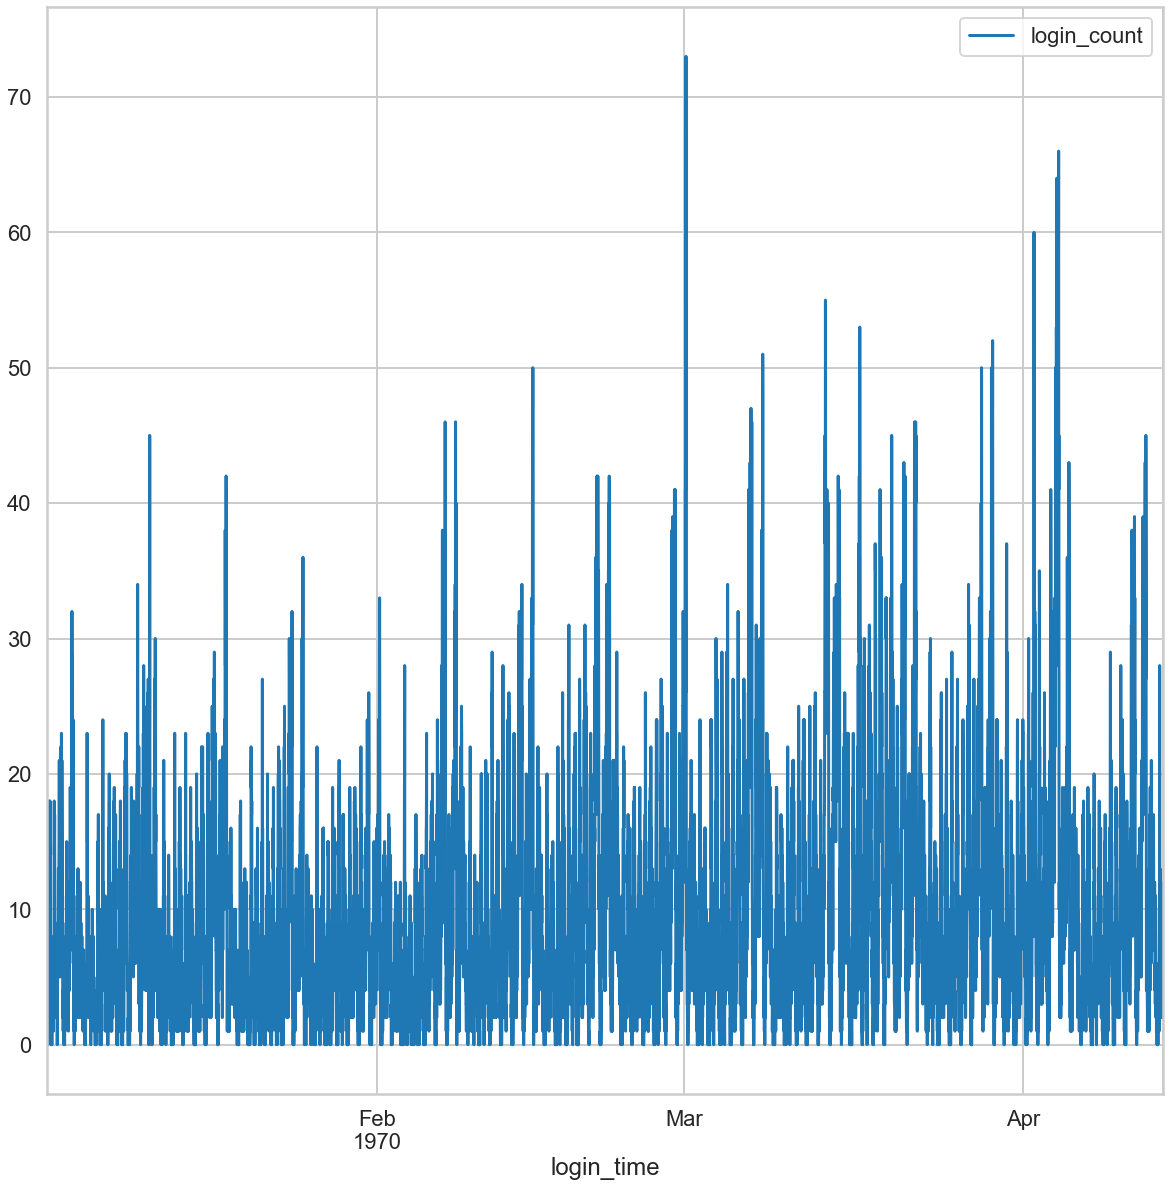

In [4]:
sns.set_style('whitegrid')
sns.set_context('poster')
logins15 = loginsdf.resample('15Min').count()
logins15.plot(figsize = (20,20))

# Daily Time Series Plot
A daily lineplot tells us that there is definitely a weekly pattern. There could potentially also be an annual seasonal cycle, but we do not have enough data to tell.

<AxesSubplot:xlabel='login_time'>

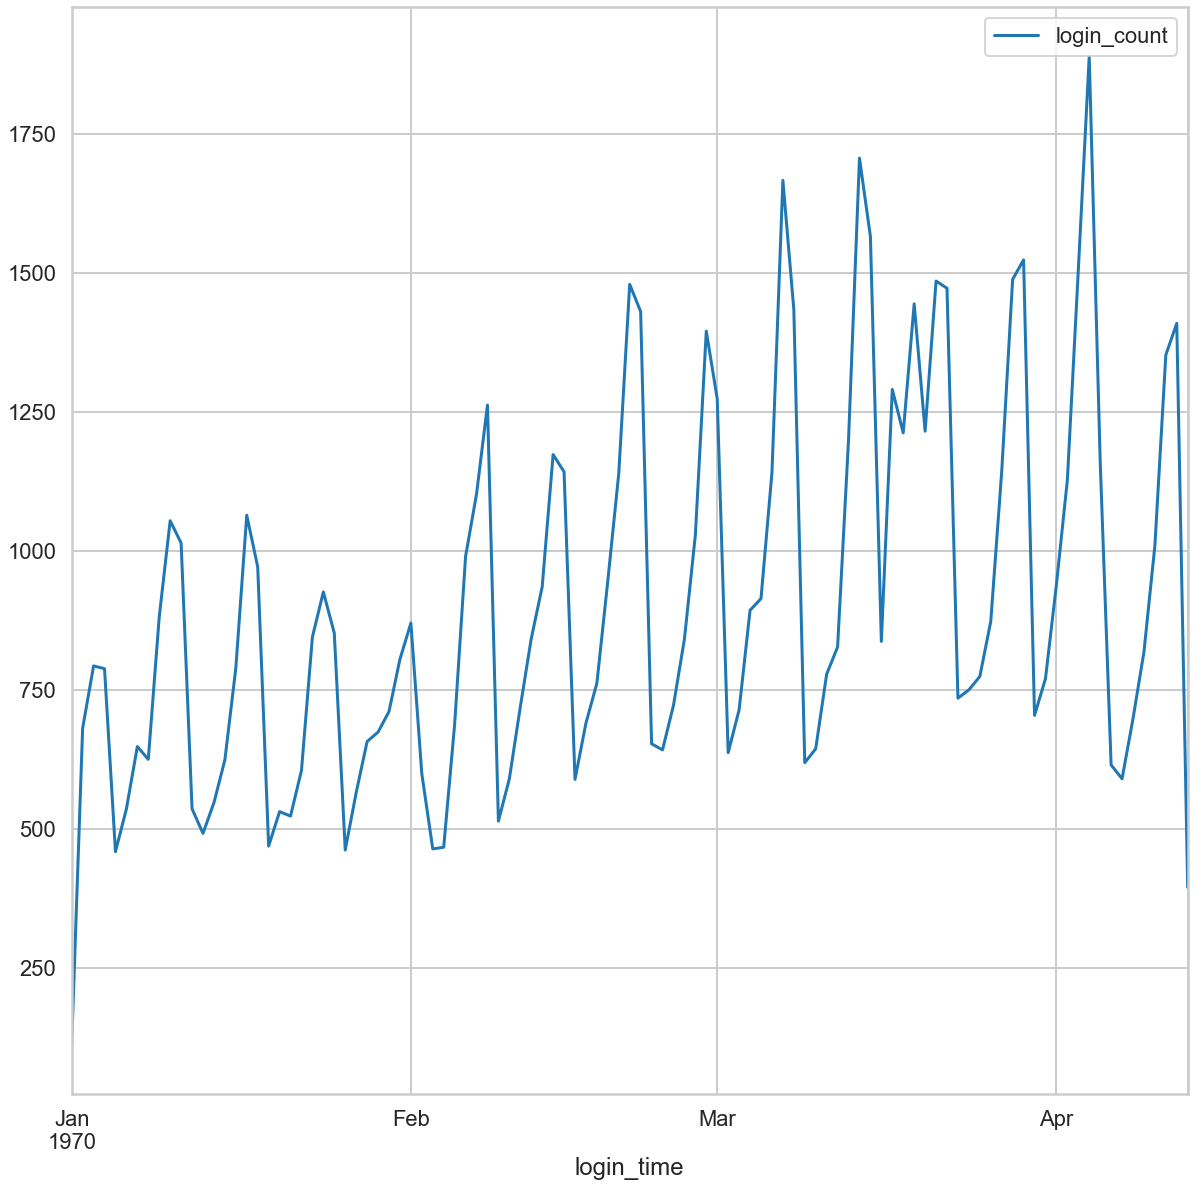

In [5]:
loginsday = loginsdf.resample('D').count()
loginsday.plot(figsize = (20,20))

In [6]:
loginsday['weekday'] = loginsday.index.weekday
logins_by_weekday = pd.pivot_table(loginsday, values = 'login_count', index = 'weekday', aggfunc = ['mean', 'median', 'max', 'min'])
logins_by_weekday.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
logins_by_weekday

,mean,median,max,min
,login_count,login_count,login_count,login_count
Monday,588.200000,599.0,837,395
Tuesday,662.000000,616.0,1290,464
Wednesday,738.500000,720.5,1212,467
Thursday,797.333333,827.0,1444,112
Friday,1013.866667,1009.0,1504,681
Saturday,1291.800000,1352.0,1889,793
Sunday,1211.133333,1262.0,1565,788


# 7-Day Smoothed Time Series Plot
Looking at the 7-day smoothed lineplot shows us that when we account for the weekly cyclical pattern, there is still a long-term upward trend in logins, with a slight downturn towards the end of the data.

<AxesSubplot:xlabel='login_time', ylabel='login_count'>

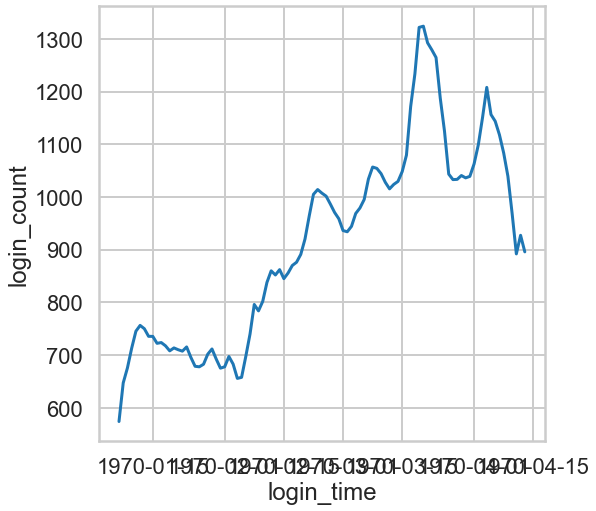

In [7]:
logins_smoothed = loginsday.rolling(7).mean()
plt.figure(figsize = (8,8))
sns.lineplot(x = logins_smoothed.index, y = logins_smoothed.login_count)

# A Closer Look at the Weekly Pattern
Taking a closer look at the weekly pattern shows that people tend to log in more as the days move from Monday towards the weekend.

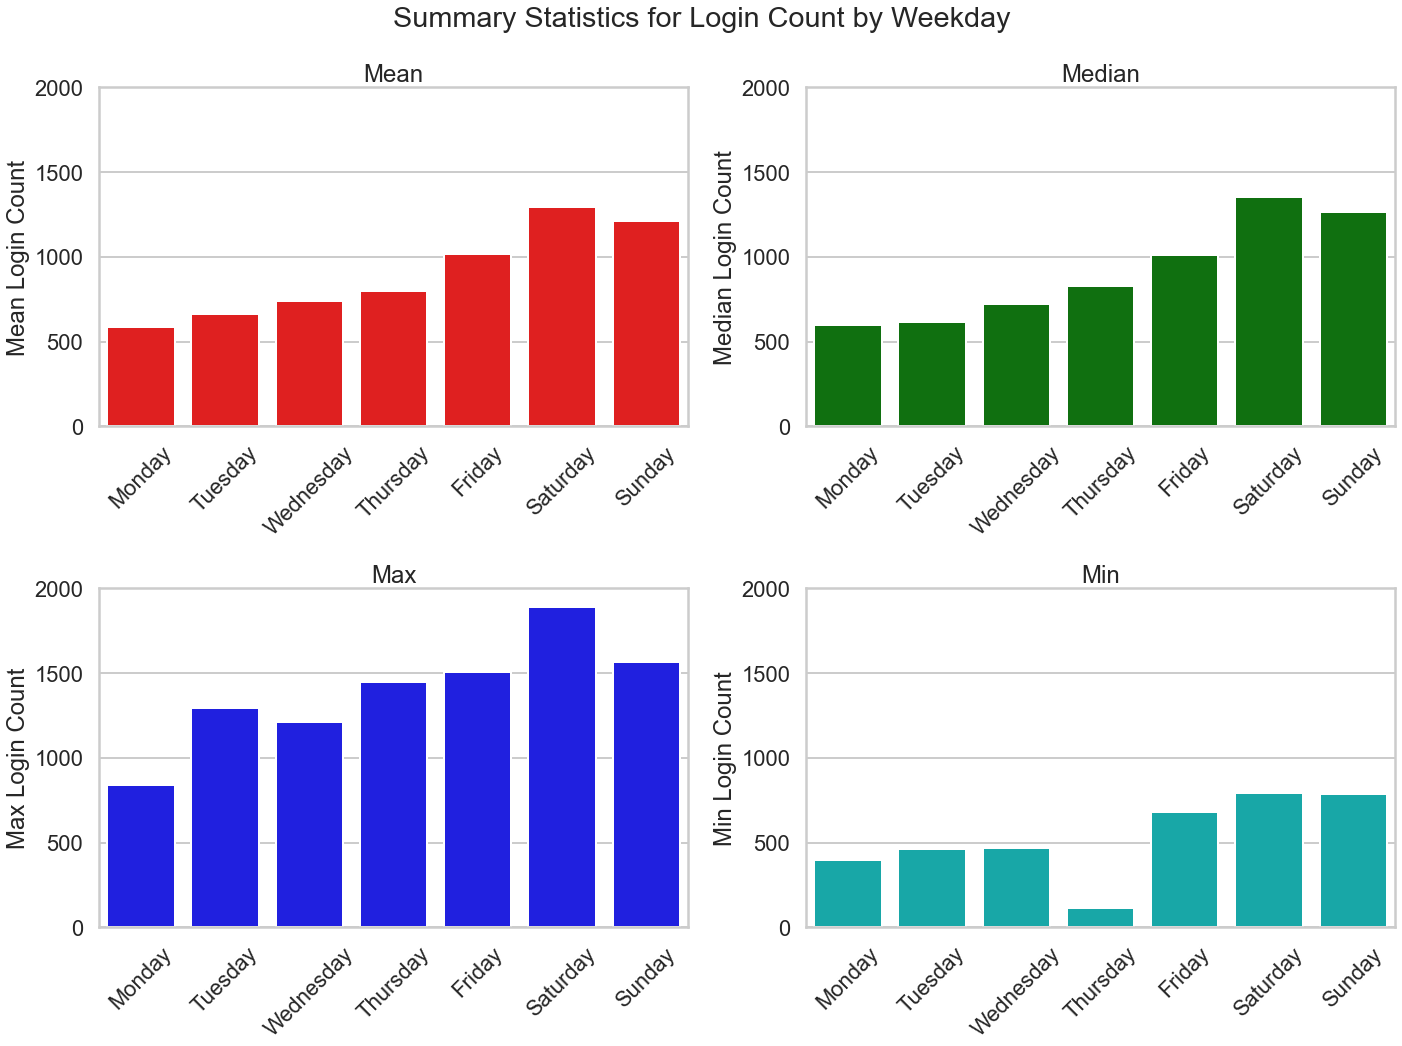

In [8]:
sns.set_context('poster')
sns.set_style('whitegrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20,15))

sns.barplot(x = logins_by_weekday.index, y = logins_by_weekday['mean']['login_count'], color = 'r', ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax1.set_title('Mean')
ax1.set_ylabel('Mean Login Count')
ax1.set_ylim(0,2000)

sns.barplot(x = logins_by_weekday.index, y = logins_by_weekday['median']['login_count'], color = 'g', ax = ax2)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax2.set_title('Median')
ax2.set_ylabel('Median Login Count')
ax2.set_ylim(0,2000)

sns.barplot(x = logins_by_weekday.index, y = logins_by_weekday['max']['login_count'], color = 'b', ax = ax3)
ax3.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax3.set_title('Max')
ax3.set_ylabel('Max Login Count')
ax3.set_ylim(0,2000)

sns.barplot(x = logins_by_weekday.index, y = logins_by_weekday['min']['login_count'], color = 'c', ax = ax4)
ax4.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax4.set_title('Min')
ax4.set_ylabel('Min Login Count')
ax4.set_ylim(0,2000)

fig.suptitle('Summary Statistics for Login Count by Weekday')
plt.tight_layout()
plt.show()

# Part 2 - Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


# Part 2 - Answer

1. In order to track this type of metric, we would ideally have per-driver metrics, not just a simple time series. Assuming that we had information on each driver, the key metric of success would be "Average driver bridge crosses per day". This would allow us to tell whether the program is working, and how much it is working. It could then also be used to calculate the total cost of the program (average crosses per day * total drivers * toll price) to evaluate whether the program is cost effective.

2. 
Step 1: Collect driver data for at least one week but preferably many weeks before. Step 2: Collect driver data for equivalent time period with the deal in place.
Step 3: Calculate "Average driver bridge crosses per day" for each driver in the period before the deal, and during the deal.
Step 4: Perform paired t-test to determine whether the bridge crosses during the deal are higher than beforehand.
Step 5: Calculate total cost of the program, and present to the city operations team along with summary statistics such as average driver bridge cross increase, whether total rides went up, etc.



# Part 3 - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

# Load Data

In [9]:
riders = pd.read_json('ultimate_data_challenge.json')
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [10]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [11]:
riders.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


# Explore and Clean Data

In [12]:
# Change to datetime
riders['signup_date'] = pd.to_datetime(riders['signup_date'], yearfirst = True)
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'], yearfirst = True)


# Change to int
riders['ultimate_black_user'] = riders['ultimate_black_user'].astype('int')

# Convert to account age in days
riders['account_age'] = [x.days for x in (riders.last_trip_date.max() - riders.signup_date)]

# Fill with most common value (iPhone), then convert to int since there are only two values
riders.phone.fillna(value = 'iPhone', inplace = True)
riders['iPhone'] = pd.Series(riders['phone'] == 'iPhone').astype('int')

# Fill with median
riders.avg_rating_by_driver.fillna(value = riders.avg_rating_by_driver.median(skipna = True), inplace = True)

The rest of the missing values are in avg_rating_of_driver, and there are a lot of them, which leads me to believe that there may be some pattern causing them. Based on the statistics in the two tables below, it appears that the null values are caused by people who haven't left any driver ratings whatsoever. 

The lowest average rating of driver for non-null values is 1.0, so we can set these null values as 0 and they will still be differentiable from the non-null values.

In [13]:
riders[riders['avg_rating_of_driver'].isnull()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_age,iPhone
count,8122.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000
mean,0.593327,NaN,1.078210,8.548067,0.336740,59.050948,7.506267,4.787749,165.078675,0.644423
std,0.606755,NaN,0.310306,26.578461,0.472624,46.859739,7.758616,0.619853,8.845113,0.478717
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,151.000000,0.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,2.410000,5.000000,157.000000,0.000000
50%,1.000000,NaN,1.000000,0.000000,0.000000,100.000000,4.715000,5.000000,164.000000,1.000000
75%,1.000000,NaN,1.000000,0.000000,1.000000,100.000000,10.720000,5.000000,172.000000,1.000000
max,5.000000,NaN,5.000000,100.000000,1.000000,100.000000,160.960000,5.000000,181.000000,1.000000


In [14]:
riders[riders['avg_rating_of_driver'].isnull() == False].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_age,iPhone
count,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000
mean,2.604972,4.601559,1.074095,8.908004,0.384904,61.289756,5.465290,4.777363,165.528368,0.710254
std,4.055311,0.617338,0.200861,18.401140,0.486578,34.858046,5.151833,0.403660,8.734709,0.453650
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,151.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,37.500000,2.420000,4.700000,158.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.790000,5.000000,165.000000,1.000000
75%,3.000000,5.000000,1.070000,11.100000,1.000000,100.000000,6.490000,5.000000,173.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,79.690000,5.000000,181.000000,1.000000


In [15]:
riders['avg_rating_of_driver'].fillna(value = 0, inplace = True)

# Create Target Variable and Dummy Variables

In [16]:
onemonthprior = riders.last_trip_date.max() - pd.Timedelta('30D')
riders['target'] = pd.Series((riders.last_trip_date > onemonthprior)).astype('int')

In [17]:
# One last cleanup step, we need to create dummy vars for the city variable
riders2 = pd.get_dummies(riders, columns = ['city'])

In [18]:
riders2.target.sum() / len(riders2)

0.3662

# Preprocessing

In [19]:
X = riders2.drop(['signup_date', 'last_trip_date','phone', 'target'], axis = 1)
y = riders2[['target']]
y = np.ravel(y)

In [20]:
# Import model, preprocessing and evaluation modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 13), (10000, 13), (40000,), (10000,))

# Train Model 1

In [21]:
rf = RandomForestClassifier()
params = {'n_estimators': [100],
         'max_depth': randint(10, 50),
         'min_samples_split': randint(2,20),
         'min_samples_leaf': randint(1, 20),
         'n_jobs': [-1]
        }

cvrf = RandomizedSearchCV(rf, param_distributions = params, n_iter = 10, n_jobs = -1, scoring = 'f1', random_state = 123)
cvrf.fit(X_train, y_train)


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001444FAE9A90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001444FAE9DF0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001444FC28880>,
                                        'n_estimators': [100], 'n_jobs': [-1]},
                   random_state=123, scoring='f1')

In [22]:
pd.DataFrame(cvrf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.999785,0.754605,1.436962,0.678724,12,3,8,100,-1,"{'max_depth': 12, 'min_samples_leaf': 3, 'min_...",0.696207,0.683526,0.694878,0.684615,0.698540,0.691553,0.006231,1
7,2.213105,0.746371,1.379950,0.543774,12,8,4,100,-1,"{'max_depth': 12, 'min_samples_leaf': 8, 'min_...",0.697298,0.682344,0.690856,0.691746,0.692040,0.690857,0.004820,2
2,2.021013,1.045730,1.229124,0.843809,42,18,17,100,-1,"{'max_depth': 42, 'min_samples_leaf': 18, 'min...",0.697529,0.680015,0.691682,0.687489,0.693270,0.689997,0.005937,3
3,2.734551,0.475580,1.002987,0.450384,19,1,16,100,-1,"{'max_depth': 19, 'min_samples_leaf': 1, 'min_...",0.695397,0.685383,0.687854,0.685537,0.693387,0.689512,0.004129,4
8,2.390553,0.315858,0.826804,0.184400,30,16,18,100,-1,"{'max_depth': 30, 'min_samples_leaf': 16, 'min...",0.693629,0.681835,0.689998,0.688500,0.692634,0.689319,0.004164,5
1,2.775914,0.270679,0.690953,0.209870,27,11,3,100,-1,"{'max_depth': 27, 'min_samples_leaf': 11, 'min...",0.697632,0.680058,0.687523,0.687938,0.693211,0.689272,0.005918,6
5,2.593971,0.730188,0.954472,0.796824,46,1,18,100,-1,"{'max_depth': 46, 'min_samples_leaf': 1, 'min_...",0.698866,0.679689,0.691163,0.685117,0.691462,0.689259,0.006473,7
4,3.003700,0.467113,0.963131,0.858049,42,16,16,100,-1,"{'max_depth': 42, 'min_samples_leaf': 16, 'min...",0.695700,0.680379,0.688561,0.688367,0.691644,0.688930,0.005035,8
6,2.854874,0.203943,0.453610,0.176649,14,18,5,100,-1,"{'max_depth': 14, 'min_samples_leaf': 18, 'min...",0.694996,0.680015,0.688992,0.686854,0.693240,0.688819,0.005275,9
9,2.170066,0.854340,0.139627,0.140557,17,10,5,100,-1,"{'max_depth': 17, 'min_samples_leaf': 10, 'min...",0.698830,0.679389,0.690138,0.685515,0.687500,0.688275,0.006357,10


In [23]:
rf = cvrf.best_estimator_
y_pred = rf.predict(X_test)
classification_report(y_test, y_pred, output_dict = True)['1']

{'precision': 0.7486697965571205,
 'recall': 0.649470540320391,
 'f1-score': 0.6955510322768247,
 'support': 3683}

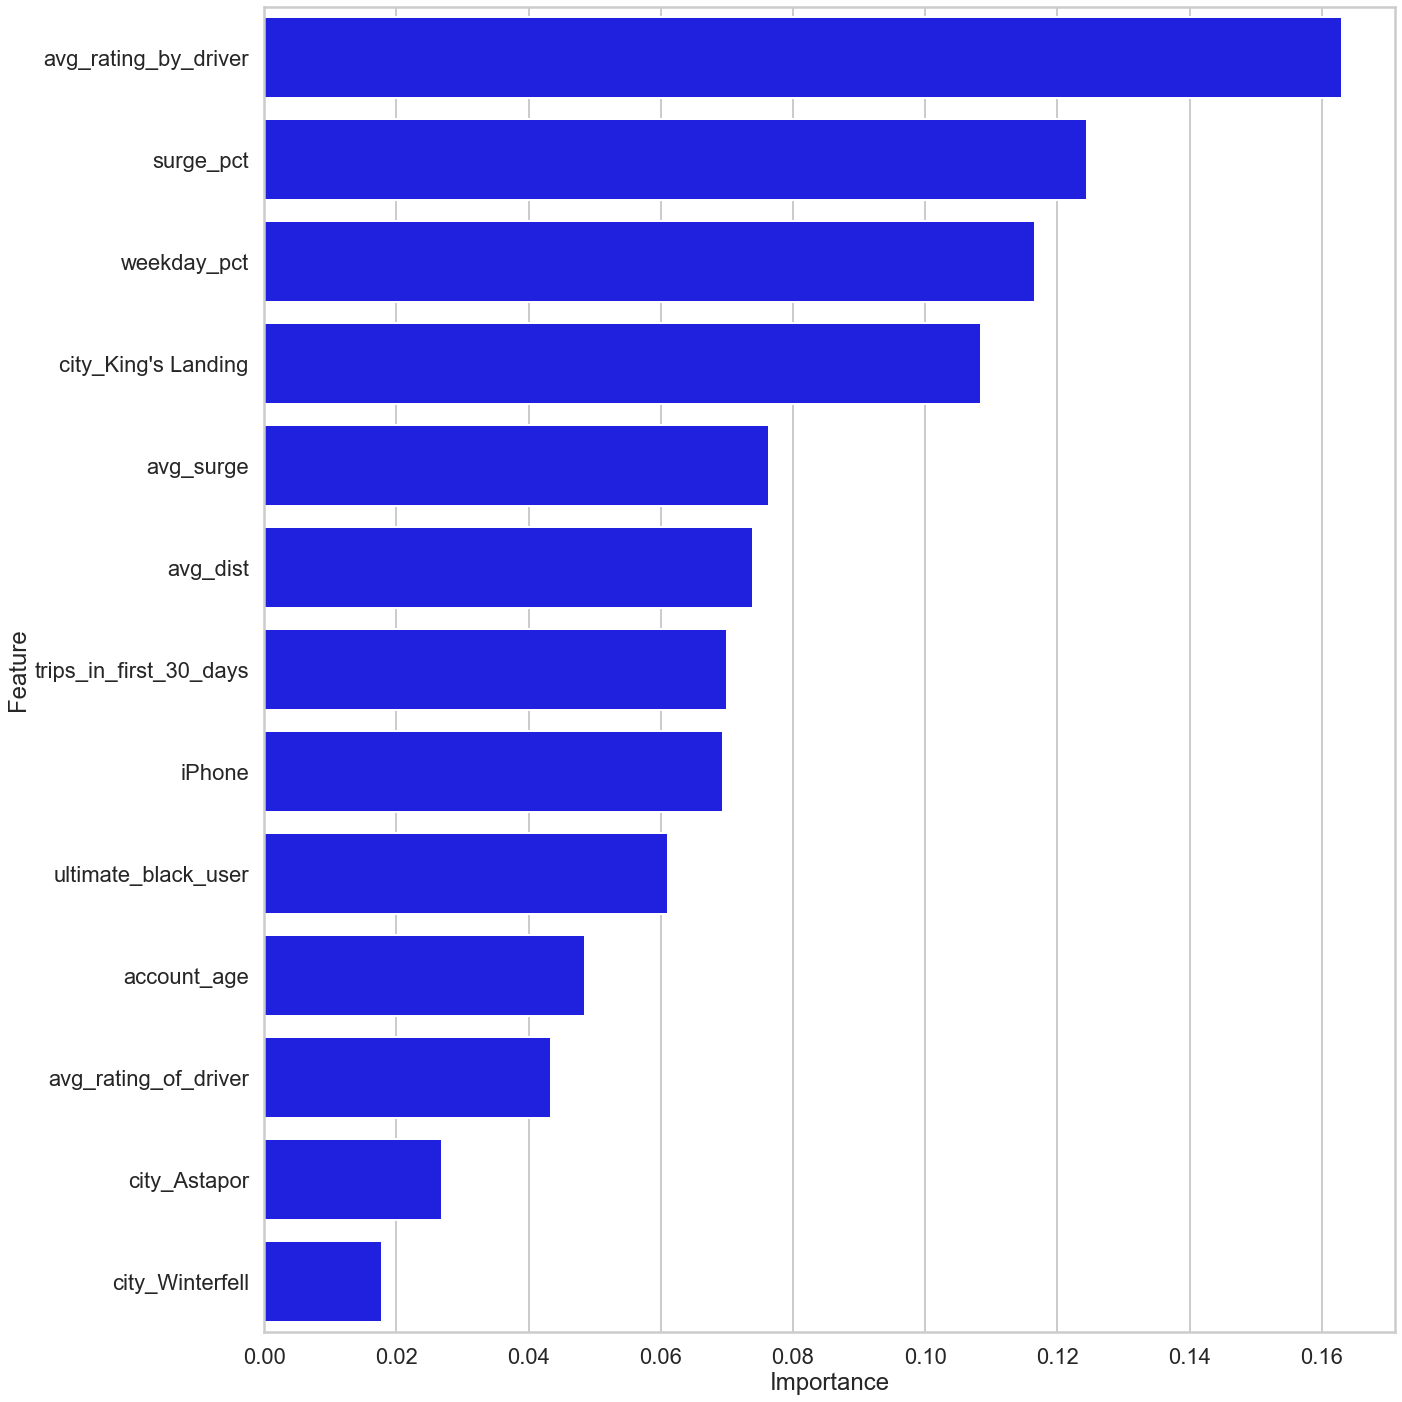

In [24]:
rffeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = rffeatureimportance, color = 'b')
plt.tight_layout()

# Train Model 2

In [25]:
#%conda install xgboost

xg = XGBClassifier()
params = {'n_estimators': [100],
         'max_depth': randint(2, 5),
         'learning_rate': uniform(0,0.3),
         'verbosity': [1],
         'n_jobs': [-1]
        }

cvxg = RandomizedSearchCV(xg, param_distributions = params, n_iter = 10, n_jobs = -1, scoring = 'f1', random_state = 123)
cvxg.fit(X_train, y_train)


C:\Users\atyou\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:26:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=N

In [26]:
pd.DataFrame(cvxg.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_verbosity,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.925294,0.168239,0.017354,0.003546,0.165394,4,100,-1,1,"{'learning_rate': 0.16539443072486737, 'max_de...",0.707820,0.701767,0.706030,0.698018,0.708993,0.704526,0.004075,1
0,2.832153,0.112843,0.015758,0.000977,0.208941,4,100,-1,1,"{'learning_rate': 0.2089407556793585, 'max_dep...",0.705498,0.700910,0.707847,0.697063,0.706580,0.703580,0.004012,2
3,3.010872,0.059408,0.019747,0.002555,0.126932,4,100,-1,1,"{'learning_rate': 0.1269319380373383, 'max_dep...",0.704879,0.700551,0.708879,0.696280,0.705819,0.703282,0.004400,3
7,2.955100,0.260185,0.014162,0.001163,0.218715,4,100,-1,1,"{'learning_rate': 0.21871491221521247, 'max_de...",0.702162,0.702093,0.704357,0.698826,0.707264,0.702941,0.002791,4
1,3.080689,0.052478,0.018750,0.002778,0.128541,4,100,-1,1,"{'learning_rate': 0.12854127785604771, 'max_de...",0.704389,0.699716,0.710489,0.694790,0.705137,0.702904,0.005305,5
9,1.667351,0.422849,0.011968,0.001892,0.178171,3,100,-1,1,"{'learning_rate': 0.1781707199022071, 'max_dep...",0.705240,0.698288,0.701920,0.695809,0.701393,0.700530,0.003230,6
5,2.342459,0.127733,0.017952,0.001669,0.14428,3,100,-1,1,"{'learning_rate': 0.14427957044530829, 'max_de...",0.702791,0.693172,0.701350,0.697095,0.702761,0.699434,0.003760,7
4,2.136393,0.149664,0.016356,0.001850,0.123277,3,100,-1,1,"{'learning_rate': 0.12327731181270568, 'max_de...",0.700907,0.692403,0.701748,0.696371,0.702517,0.698789,0.003841,8
6,1.728380,0.015270,0.016556,0.001017,0.120305,2,100,-1,1,"{'learning_rate': 0.12030526699836105, 'max_de...",0.697097,0.684465,0.691555,0.691487,0.696992,0.692319,0.004639,9
8,1.595534,0.078668,0.014960,0.000892,0.0179034,2,100,-1,1,"{'learning_rate': 0.017903368982870503, 'max_d...",0.645352,0.639647,0.639389,0.620192,0.649814,0.638879,0.010115,10


In [27]:
xg = cvxg.best_estimator_
y_pred = xg.predict(X_test)
classification_report(y_test, y_pred, output_dict = True)['1']

{'precision': 0.7443631931748934,
 'recall': 0.6633179473255498,
 'f1-score': 0.7015075376884422,
 'support': 3683}

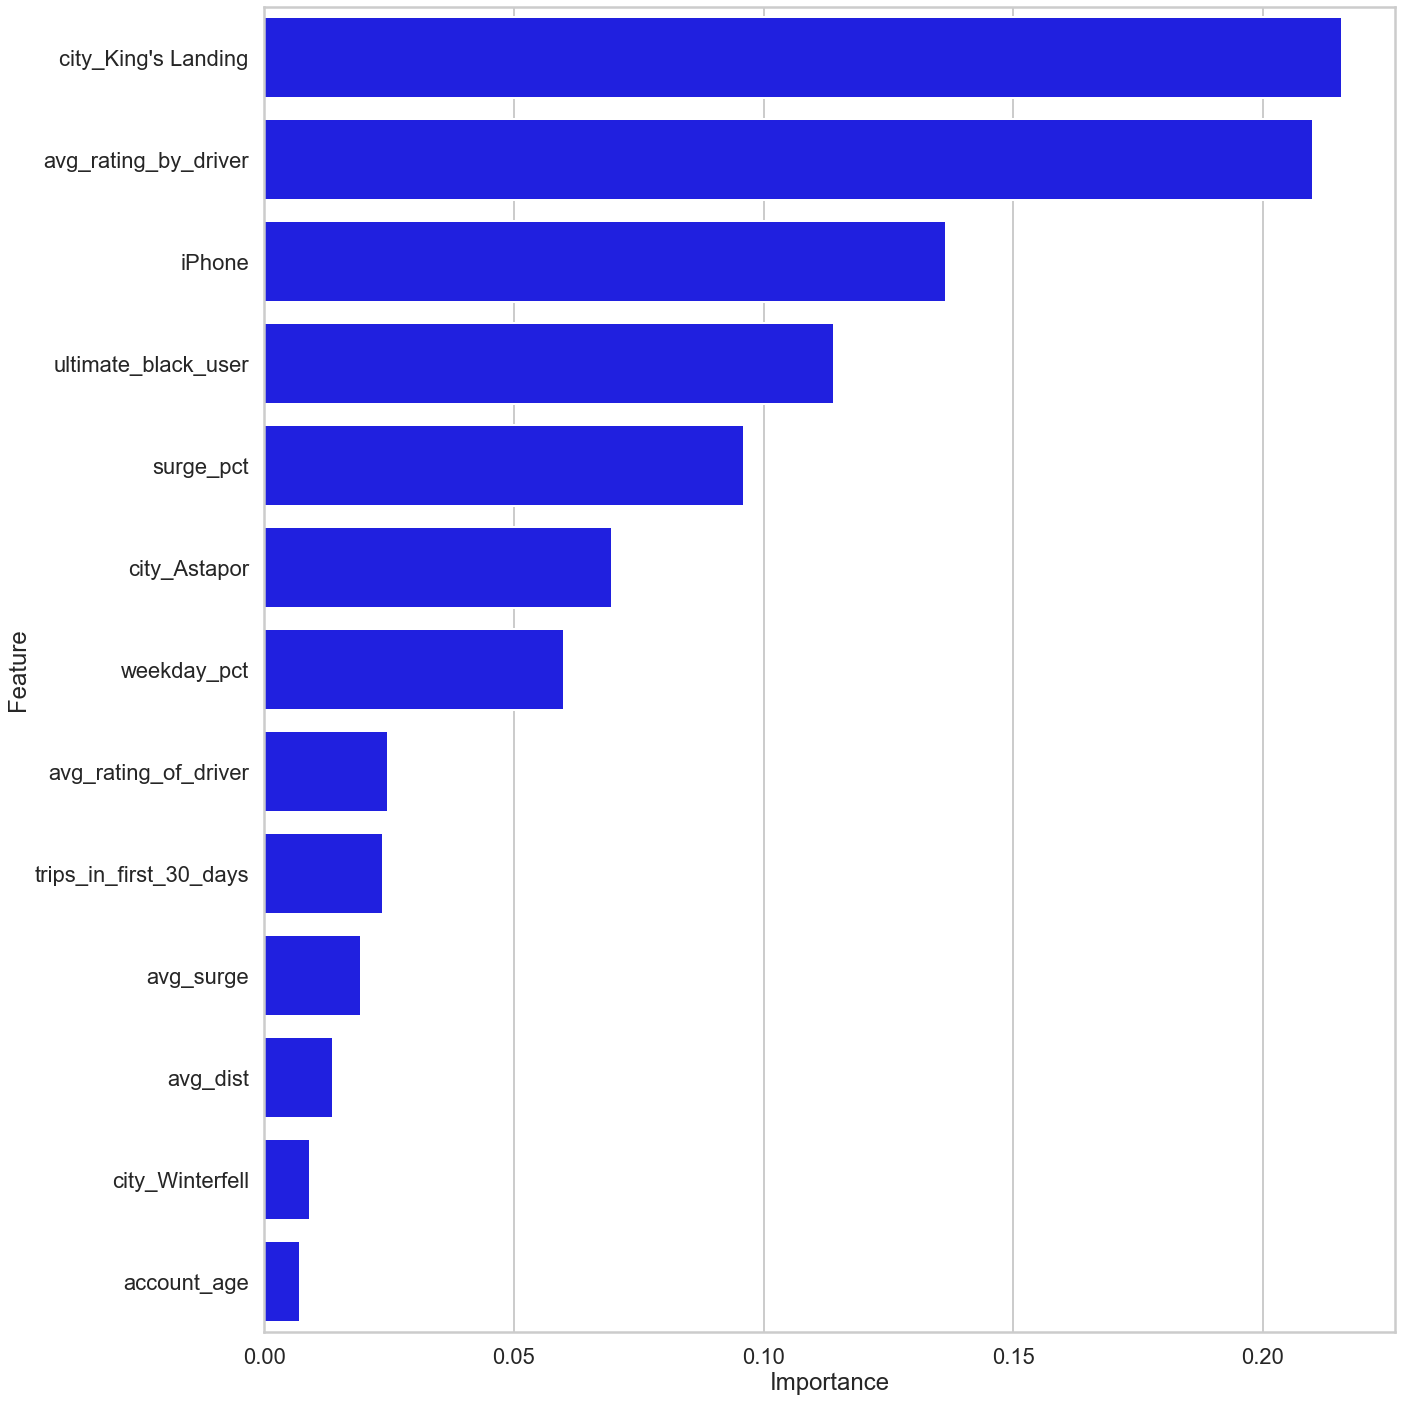

In [28]:
xgfeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xg.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = xgfeatureimportance, color = 'b')
plt.tight_layout()

In [29]:
# Plotting Helper Functions

def plot_cat_vs_binary_target(df, target, variables):
    """Plot barplots of a set of categorical variables against a binary target"""
    
    # Determine subplot layout for given number of plots
    subplotsdict = {
        1: (1,1),
        2: (1,2),
        3: (2,2),
        4: (2,2),
        5: (3,2),
        6: (3,2),
        7: (3,3),
        8: (3,3),
        9: (3,3),
        10:(4,3),
        11:(4,3),
        12:(4,3)
    }
    
    # Set basic layout of plots
    sns.set_context('poster')
    sns.set_style('whitegrid')
    
    # create subplots
    r, c = subplotsdict[len(variables)]
    fig, axes = plt.subplots(r, c, figsize = (20,20))
    
    for i in range(len(variables)):
        
        data = pd.pivot_table(df, index = variables[i], values = target, aggfunc = 'mean')
        
        if len(variables) == 1:
            ax = axes
        else:
            ax = axes.ravel()[i]
        
        sns.barplot(x = data.index, y = data[target], ax = ax)
        ax.set_xlabel(variables[i])
        ax.set_ylabel(target)
        ax.set_title(target + ' by ' + variables[i])
        
    
    plt.tight_layout()
    plt.show()




In [30]:
def plot_num_vs_binary_target(df, target, variables):
    """Plot barplots of a set of categorical variables against a binary target"""
    
    # Determine subplot layout for given number of plots
    subplotsdict = {
        1: (1,1),
        2: (1,2),
        3: (2,2),
        4: (2,2),
        5: (3,2),
        6: (3,2),
        7: (3,3),
        8: (3,3),
        9: (3,3),
        10:(4,3),
        11:(4,3),
        12:(4,3)
    }
    
    # Set basic layout of plots
    sns.set_context('poster')
    sns.set_style('whitegrid')
    
    # create subplots
    r, c = subplotsdict[len(variables)]
    fig, axes = plt.subplots(r, c, figsize = (20,20))
    
    for i in range(len(variables)):
        
        data = pd.pivot_table(df, index = target, values = variables[i], aggfunc = 'mean')
        
        if len(variables) == 1:
            ax = axes
        else:
            ax = axes.ravel()[i]
        
        sns.barplot(x = data.index, y = data[variables[i]], ax = ax)
        ax.set_ylabel(variables[i])
        ax.set_xlabel(target)
        ax.set_title(variables[i] + ' by ' + target)
        
    plt.tight_layout()
    plt.show()

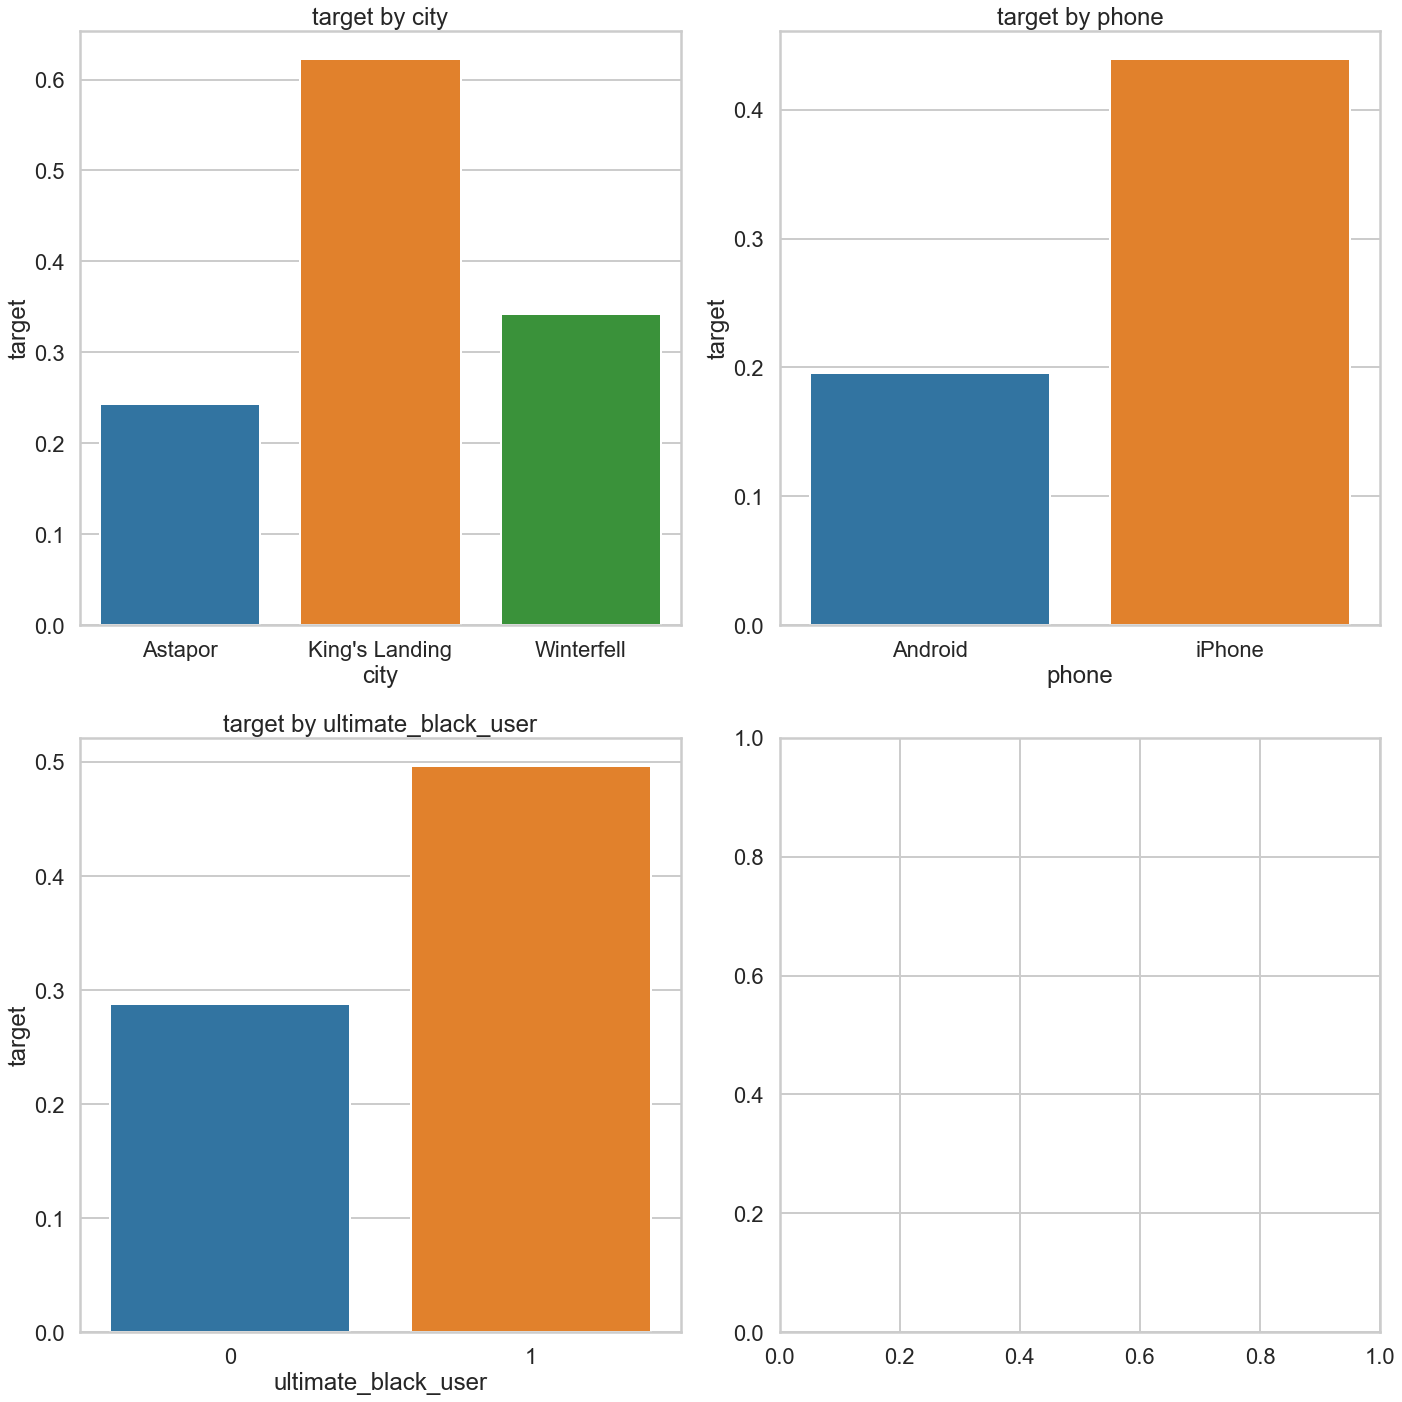

In [31]:
plot_cat_vs_binary_target(riders, 'target', ['city','phone','ultimate_black_user'])

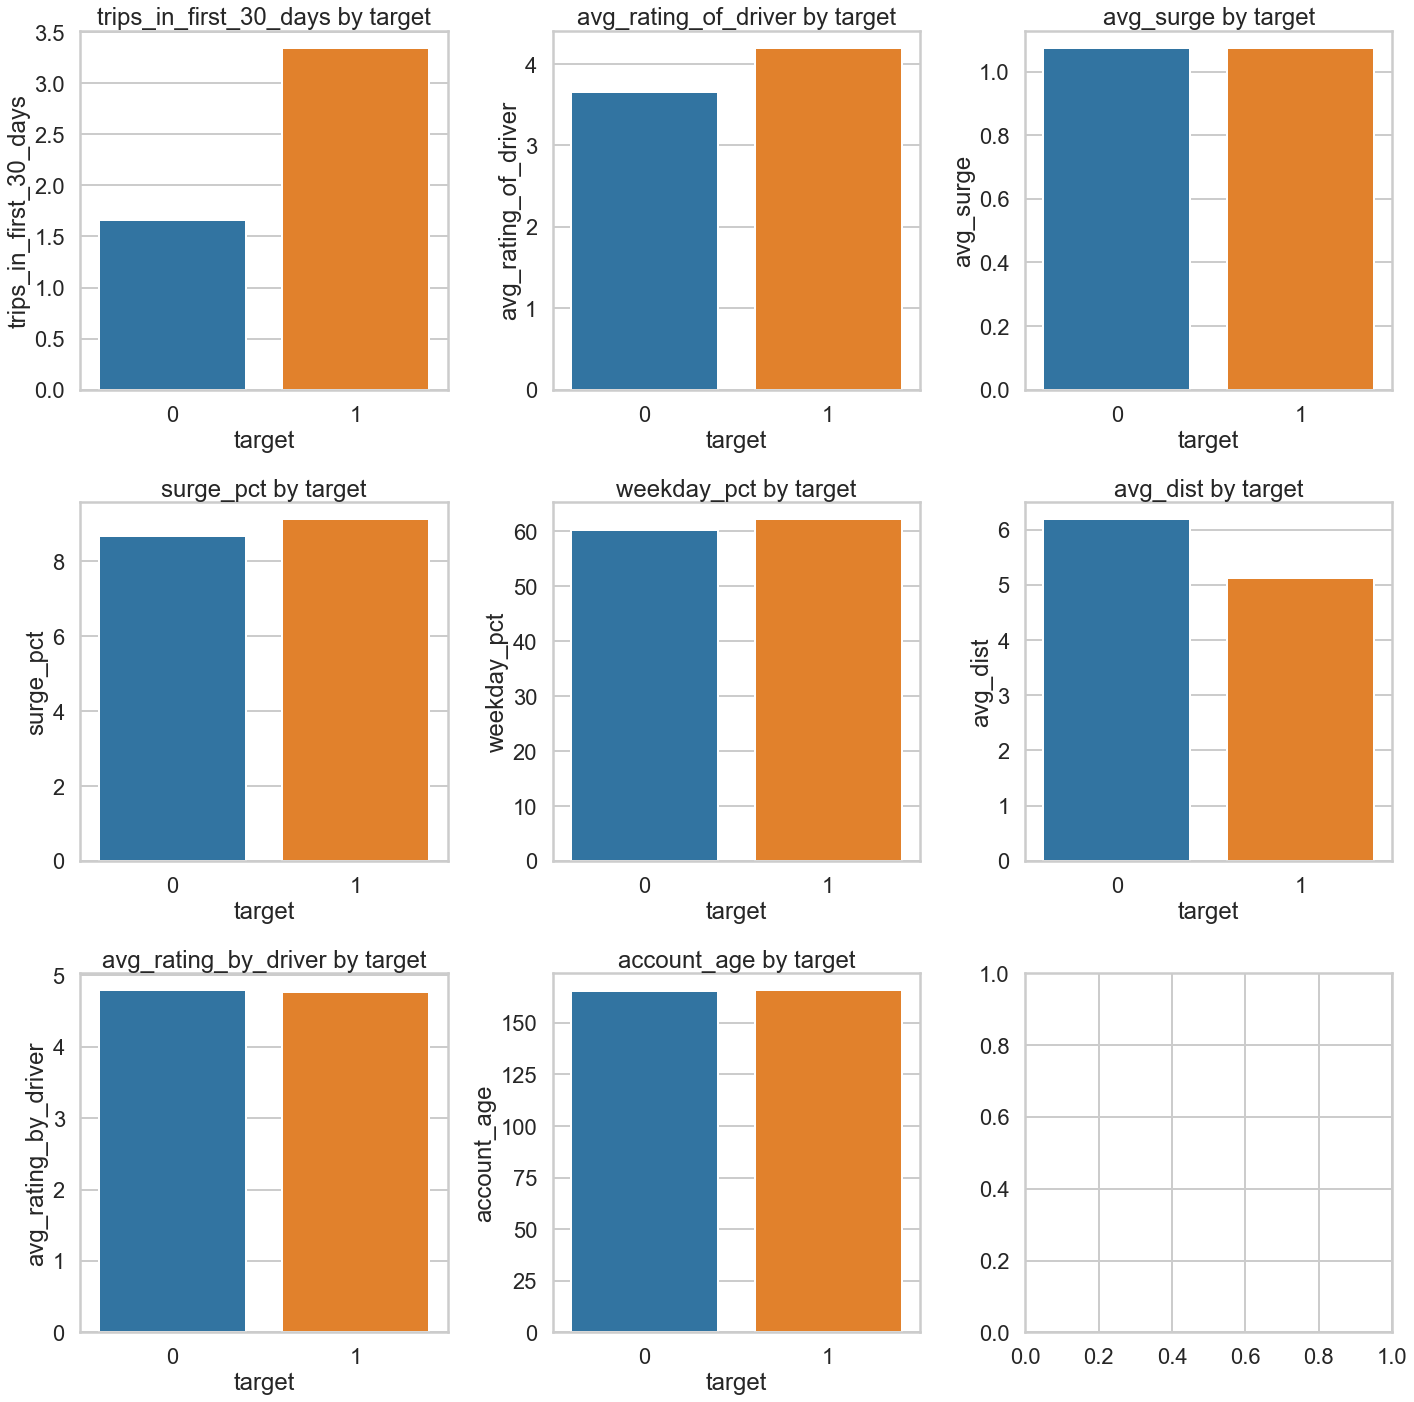

In [32]:
plot_num_vs_binary_target(riders, 'target', ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist','avg_rating_by_driver', 'account_age'])

# Part 3 - Answers

1. ~37% of riders were retained over the observed period. A significantly higher amount of riders were retained if the rider: lived in king's landing, owned an iPhone, were an ultimate black user, or had a high amount of rides in the first 30 days. My strategy will be to use two tree-based models that are flexible and generally perform well on classification tasks. The first will be a random forest and the second will be an extreme gradient boosting model.

2. The XGBoost algorithm is generally regarded as one of the best performing models on most classification tasks. XGBoost is robust to many different data types, can handle non-linear/non-monotonic numeric relationships, and can handle interactions without any explicit programming. It's sequential training procedure and weighting adjustments also allow it to handle the "tough cases" better than many other algorithms. The XGBoost model that I ran ended up performing better than the random forest by a small margin. Based on the performance metrics below, the model does a decent job of predicting customer retention, with an f1-score of 0.7015 on the test set. The recall of the model is slightly low at 0.6633, but this could be improved with class weight adjustments.

    'precision': 0.7443631931748934,
    'recall': 0.6633179473255498,
    'f1-score': 0.7015075376884422,
    'support': 3683
 
 
3. The 3 main actionable insights provided by the model are:

iPhone users are retained much more often than android users. Perhaps Ultimate needs to invest more in developing their android app.

King's Landing users are retained much more often than the other two cities. Are there some factors that are causing increased prices in the other two cities? Are there not enough drivers in the other two cities? Further research is needed.

Ultimate Black users are much more likely to be retained than non-Ultimate Black users. Perhaps increasing the marketing of the Ultimate Black program or offering short-term discounts would be beneficial for customer retention.